<a href="https://colab.research.google.com/github/s1250103/Public_mori-lab/blob/confirm_label_noize_for_cm_data/eras/confirm_label/examine_KTH_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#環境設定

In [1]:
%tensorflow_version 2.x

## import
# file dealing
import os
from os import path

import shutil
from google.colab import drive
import datetime
# data dealing
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
# process deasing
import gc
from time import sleep

# machine learning (back)
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, initializers, callbacks

# machine learning
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical

import json
from collections import OrderedDict
import pprint
import re
import requests

In [16]:
def send_line_notify(notification_message):
    """
    LINEに通知する
    """
    line_notify_token = 'cHdELzsau6ve8hNVL3FxPz65Jdyquzuj2kd021u8q1L'
    line_notify_api = 'https://notify-api.line.me/api/notify'
    headers = {'Authorization': f'Bearer {line_notify_token}'}
    data = {'message': notification_message}
    requests.post(line_notify_api, headers = headers, data = data)

# 実験条件（外乱）を定める

In [2]:
LABEL_NOISE_RATE = 0
TEST_DATA_RATE = 0.25

#学習条件を定める

##学習手法の仕様

In [30]:
seed = 20201218
np.random.seed(seed)
tf.random.set_seed(seed)

learningDict = {
    "optimizer" : {
        "this.optimizer" : "sgd",
        "learning_rate" : 0.01,
        "momentum" : 0.9,
        "decay" : 1e-4,
        "nesterov" : True
    },
    "theWay" : {
        "batch_size" : 32,
        "epochs" : 128,
    },
    "compared_losses" : [
                        #  tf.keras.losses.CategoricalCrossentropy(),
                        #  tf.keras.losses.MeanSquaredError(), 
                         tf.keras.losses.MeanAbsoluteError(),
                        #  tf.keras.losses.SquaredHinge()               
    ]
}

def compile_optimizer():
  # 最適化処理 (adamのみ対応)
  if learningDict["optimizer"]["this.optimizer"] == "adam":
    optimizer = keras.optimizers.Adam(
        lr=learningDict["optimizer"]["learning_rate"],
        beta_1=learningDict["optimizer"]["beta_1"],
        beta_2=learningDict["optimizer"]["beta_2"])
    print("adam is used as a optimizer")

  elif learningDict["optimizer"]["this.optimizer"] == "Nadam":
    optimizer = keras.optimizers.Nadam(
        lr=learningDict["optimizer"]["learning_rate"],
        beta_1=learningDict["optimizer"]["beta_1"],
        beta_2=learningDict["optimizer"]["beta_2"],
        epsilon=None, 
        schedule_decay=0.4)
    print("Nadam is used as a optimizer")

  elif learningDict["optimizer"]["this.optimizer"] == "sgd":
    optimizer = keras.optimizers.SGD(
        lr=learningDict["optimizer"]["learning_rate"],
        momentum=learningDict["optimizer"]["momentum"],
        decay=learningDict["optimizer"]["decay"],
        nesterov=learningDict["optimizer"]["nesterov"]) 
    print("sgd is used as a optimizer")
  else:
    print("error")
  
  return optimizer

## モデルの仕様（ニューラルネットワーク）
<ul>
  <li>入力層(フレームサイズ, フレームの高さ, フレームの横幅, RGB情報) </li>
  <li>出力層(予測値) </li>
  <li> 中間層 
    <ol>
      <li>conv0</li>
      <li>pool0</li>
      <li>conv1</li>
      <li>pool1</li>
      <li>dence0</li>
  </li>
</ui>

In [4]:
def make_model(video_format):
  # モデル作成
  model = models.Sequential()
  # 入力層
  model.add(
      layers.Reshape(
          (video_format.FRAME_SIZE,
          video_format.HEIGHT,
          video_format.WIDTH,
          video_format.COLORinfo),
          input_shape=(video_format.FRAME_SIZE * video_format.HEIGHT * video_format.WIDTH * video_format.COLORinfo,),
          name='Input_Layer' )
  )
  # 畳み込み0
  model.add(
      layers.Conv3D(
          filters=32,
          kernel_size=(3, 3, 3),
          strides=(1, 1, 1),
          padding='same',
          activation='relu',
          name='conv0'))
  # pool0
  model.add(
      layers.MaxPooling3D(pool_size=(2, 2, 2), name='pool0'))

  # 畳み込み1
  model.add(
      layers.Conv3D(
          filters=32,
          kernel_size=(3, 3, 3),
          strides=(1, 1, 1),
          padding='same',
          activation='relu',
          name='conv1'))
  # pool1
  model.add(
      layers.MaxPooling3D(pool_size=(2, 2, 2), name='pool1'))

  ## 全結合0
  model.add(
      layers.Flatten(name='pipe'),
  )
  model.add(
      layers.Dense(1024,
        activation='relu',
        name='dence0' ),
  )
  # 出力層
  model.add(
      layers.Dense(4, activation='softmax', name='WATERSUPPLY')
  )
  return model


##データの仕様

In [5]:
## フォーマットの設定
class video_format:
  # 想定された入力CMデータの仕様
  playtime = "15秒"
  displaysize = "(any, any, RGB)"
  videoformat = "any"
  # モデルが扱うCMデータ(上のようなデータは、下のように変換される)
  HEIGHT = 45
  WIDTH = 80
  FRAME_SIZE = 30
  COLORinfo = 3 # "RGB"
  FPS = "2 (FRAME_SIZE / playtime)" # 定義ではなく上から計算される値

# 学習データの用意

In [6]:
## gdrive 接続
if not path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Already confirm")

## colab テンポラリディレクトリの作成
desk = '/content/desk'
if not os.path.exists(desk):
  os.mkdir(desk)
os.chdir(desk)
print("Created at /content/desk")

Mounted at /content/drive
Created at /content/desk


In [7]:
learning_data_path = "/content/drive/MyDrive/colab/cleaned_detasets/KTH"

In [8]:
if path.isdir(learning_data_path):
  print("actually exist the", learning_data_path)
  for each_data in os.listdir(learning_data_path):
    if re.match(r"Data.*\.npz", each_data):
      print("________|------------ reading [", each_data, "] as learning data.")
      learning_data_np = np.load(path.join(learning_data_path, each_data))
    elif re.match(r"Label.*\.npz", each_data):
      print("________|------------ reading [", each_data, "] as label data.")
      label_data_np = np.load(path.join(learning_data_path, each_data))
    else:
      print("Not reading such data", each_data)
else:
  print("no such path")


actually exist the /content/drive/MyDrive/colab/cleaned_detasets/KTH
Not reading such data .ipynb_checkpoints
________|------------ reading [ Data_of_KTH.npz ] as learning data.
________|------------ reading [ Label_of_KTH.npz ] as label data.


In [9]:
learning_data = []
label_data = []
for i in learning_data_np.files:
  learning_data.append(learning_data_np[i])
for i in label_data_np.files:
  label_data.append(label_data_np[i])

learning_data = np.array(learning_data)
label_data = np.array(label_data)
label_data = tf.keras.utils.to_categorical(label_data, 4)

## 訓練データとテストデータとで分割

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(learning_data, label_data, random_state=20200120, train_size=(1-TEST_DATA_RATE))

## テストデータに意図的なノイズを加える(実験のために)

In [13]:
import random
def rand_ints_nodup(a, b, k):
  ns = []
  while len(ns) < k:
    n = random.randint(a, b)
    if not n in ns:
      ns.append(n)
  return ns
def changed_number(original_num, set_min, set_max):
  while True:
    tmpRndVal = random.randint(set_min, set_max)
    if original_num != tmpRndVal:
      return tmpRndVal

In [14]:
changed_label_number_for_experiment = int(len(Y_test) * LABEL_NOISE_RATE)
change_points = rand_ints_nodup(0, len(Y_test)-1, changed_label_number_for_experiment )
print("change map:", sorted(change_points))
print("the size:", len(change_points))

set_min = np.min(Y_test)
set_max = np.max(Y_test)
if LABEL_NOISE_RATE != 0:
  for i in range(len(Y_test)):
    if i in change_points:
      print("No.", i, ", original number is", Y_test[i], end=" -> ")
      Y_test[i] = changed_number(Y_test[i], set_min, set_max)
      print("changed number is", Y_test[i])
    else:
      print("error")
      break
else:
  print("No label noizes")
  

change map: []
the size: 0
No label noizes


# 学習開始

In [33]:
%%time
obj_video_format = video_format()

histories = []
for i, each_loss in enumerate(learningDict["compared_losses"]):
  print("try", each_loss)
  send_line_notify('学習開始 ' + str(i+1) + "/" + str(each_loss))

  try:
    # モデル構築
    model = make_model(obj_video_format)
    model.compile(
          optimizer=compile_optimizer(),
          loss=each_loss,
          metrics=['acc'])
    # 実行
    
    history = model.fit(
          X_train, Y_train,
          validation_data=(X_test, Y_test),
          batch_size=learningDict["theWay"]["batch_size"],
          epochs=learningDict["theWay"]["epochs"]
          # verbose=0
          )
  except KeyboardInterrupt: 
    del model
    keras.backend.clear_session()
    gc.collect()
    print("\n\nProcessed the KeyboardInterrupt")
    print(" and the model is erased.")

  histories.append(history)
  print("Complete.")
  send_line_notify('学習完了 ' + str(i+1) + "/" + str(each_loss))

  sleep(5)
  del model
  keras.backend.clear_session()
  gc.collect()

try <tensorflow.python.keras.losses.MeanAbsoluteError object at 0x7f71cf8bd518>
sgd is used as a optimizer
Epoch 1/128
10/10 [==============================] - 4s 373ms/step - loss: 0.3766 - acc: 0.2514 - val_loss: 0.3807 - val_acc: 0.2200
Epoch 2/128
10/10 [==============================] - 3s 351ms/step - loss: 0.3745 - acc: 0.2556 - val_loss: 0.3853 - val_acc: 0.2200
Epoch 3/128
10/10 [==============================] - 3s 351ms/step - loss: 0.3700 - acc: 0.2549 - val_loss: 0.3864 - val_acc: 0.2200
Epoch 4/128
10/10 [==============================] - 4s 354ms/step - loss: 0.3731 - acc: 0.2495 - val_loss: 0.3832 - val_acc: 0.2200
Epoch 5/128
10/10 [==============================] - 3s 353ms/step - loss: 0.3516 - acc: 0.3085 - val_loss: 0.3795 - val_acc: 0.2200
Epoch 6/128
10/10 [==============================] - 3s 353ms/step - loss: 0.3564 - acc: 0.2727 - val_loss: 0.3779 - val_acc: 0.2200
Epoch 7/128
10/10 [==============================] - 3s 351ms/step - loss: 0.3588 - acc: 0.2529

# 学習可視化

In [66]:
now_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
today = now_time.strftime('%m%d')

print(today)
def plot_learning(history, experiment_name="No name"):
  HEIGHT = 1
  WIDTH = 2
  rate = 5.0
  WpH_rate = 1.5
  fig = plt.figure(figsize=(WIDTH*rate*WpH_rate, HEIGHT*rate))
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

  LOSS = fig.add_subplot(HEIGHT, WIDTH, 1) # loss, val_loss
  ACC = fig.add_subplot(HEIGHT, WIDTH, 2) # acc, val_acc

  # 1,1 loss
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  loss_props = {
        'title' : 'Loss values plot',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }
  LOSS.set(**loss_props)
  LOSS.plot(loss, label='loss', color='blue')
  LOSS.plot(val_loss, label='val_loss', color='orange')
  LOSS.legend(loc='best')

  # 1,2 acc
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  acc_props = {
        'title' : 'Accuracy values plot',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }

  ACC.set(**acc_props)
  ACC.plot(acc, label='acc', color='blue')
  ACC.plot(val_acc, label='val_acc', color='orange')
  ACC.legend(loc='best')

  #save
  image_path = path.join(desk, experiment_name+today)
  fig.savefig(image_path, bbox_inches='tight')

0121


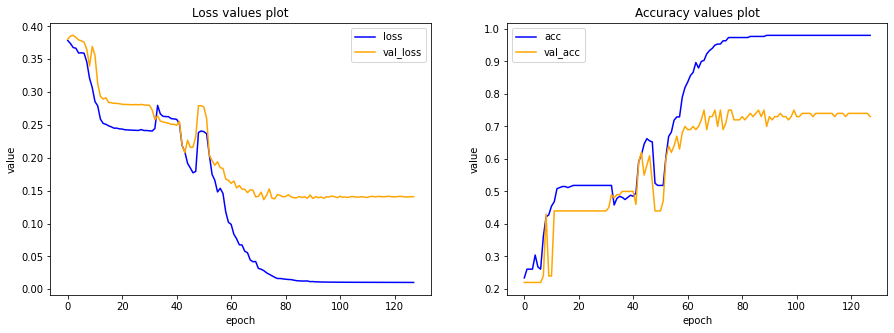

In [65]:
plot_learning(histories[0], "how_sgd_used_for_KTH_in_certain_model")

# 学習可視化データ保存

In [84]:
shelf = '/content/drive/MyDrive/colab'
book = 'tuning_results'
shelf_book = os.path.join(shelf, book)
shelf_book_page = path.join(shelf_book, today)
print(shelf_book_page)
# 保存
if not os.path.exists(shelf_book_page):
  os.makedirs(shelf_book_page)

print("Please confirm in the desk")
print("OK? y/n")
IO = input()
if IO == 'y':
  print("writing all to a strage now.")
  for each_file in os.listdir(desk):
    if re.match(r"\..*", each_file,):
      pass
    elif re.match(r".*\.png", each_file,):
      print("->", each_file)
      shutil.copy2(each_file, shelf_book_page)
    else:
      pass
else:
  pass

# for one in csvs:
#   shutil.copy2(one, shelf_book_page)

/content/drive/MyDrive/colab/tuning_results/0121
Please confirm in the desk
OK? y/n
y
writing all to a strage now.
-> how_sgd_used_for_KTH_in_certain_model0121.png
